In [1]:
#install required packages
!pip install wget
!pip install uszipcode
!pip install pandasql
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


CLEANING

Importing Libraries

In [2]:
#import required packages

from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
from google.colab import drive
import datetime as dt
from datetime import date, timedelta
from pandasql import sqldf
import itertools
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import math
import os
warnings.simplefilter(action='ignore', category=FutureWarning)
from geopy.geocoders import Nominatim
from google.colab import files
from sklearn.datasets import load_wine
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12,  6)

import wget
import time


Mounting Drive which contains our datasets

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

# define directories and file names
# download data if file is not found
data_file = 'NYPD_Complaint_Data_Current__Year_To_Date_.csv'
data_dir = 'data'
cur_dir = 'drive/MyDrive/nyc-crime-analysis/'

if not os.path.exists(cur_dir):
  os.makedirs(cur_dir)

if not os.path.exists(os.path.join(cur_dir,data_dir)):
  os.makedirs(os.path.join(cur_dir,data_dir))


if os.path.exists(os.path.join(cur_dir, data_dir, data_file)):
    print('Found data file.')
else:
    print('Downloading data file...')
    url = r'https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD'
    d_file = wget.download(url)
    print('Downloaded ', d_file)
    os.rename(d_file, os.path.join(cur_dir, data_dir, data_file))


Found data file.


Reading crime dataset from the drive location

In [5]:
OriginalDF = pd.read_csv(os.path.join(cur_dir, data_dir, data_file))

Display the Dataframe

In [6]:
OriginalDF

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,247853895,43.0,BRONX,07/11/2022,09:09:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,D,1022682.0,242998.0,40.833567,-73.861118,"(40.833567, -73.861118)",POINT (-73.861118 40.833567)
1,250722124,67.0,BROOKLYN,01/01/2021,12:00:00,09/07/2022,12:00:00,COMPLETED,(null),NaN,...,NaN,<18,BLACK,F,997843.0,175671.0,40.648851,-73.951017,"(40.6488507469884, -73.951016510623)",POINT (-73.951016510623 40.6488507469884)
2,239511545,120.0,STATEN ISLAND,12/24/2021,08:00:00,01/03/2022,08:00:00,COMPLETED,(null),NaN,...,NaN,18-24,ASIAN / PACIFIC ISLANDER,M,960911.0,165085.0,40.619768,-74.084070,"(40.619768, -74.08407)",POINT (-74.08407 40.619768)
3,247992275,115.0,QUEENS,06/15/2015,00:01:00,07/13/2022,17:00:00,COMPLETED,(null),NaN,...,NaN,45-64,WHITE,M,1013677.0,212463.0,40.749791,-73.893792,"(40.749791, -73.893792)",POINT (-73.893792 40.749791)
4,239602232,75.0,BROOKLYN,01/01/2018,09:00:00,04/14/2021,23:59:00,COMPLETED,(null),NaN,...,NaN,65+,BLACK,M,1022153.0,184000.0,40.671636,-73.863359,"(40.671636, -73.863359)",POINT (-73.863359 40.671636)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396973,251818673,46.0,BRONX,09/29/2022,08:30:00,09/29/2022,08:45:00,COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,F,1011329.0,249447.0,40.851308,-73.902116,"(40.851308, -73.902116)",POINT (-73.902116 40.851308)
396974,251891178,94.0,BROOKLYN,09/30/2022,22:55:00,09/30/2022,23:02:00,COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,D,999651.0,199731.0,40.714880,-73.944444,"(40.71488, -73.944444)",POINT (-73.944444 40.71488)
396975,251788586,79.0,BROOKLYN,09/29/2022,16:15:00,09/29/2022,16:18:00,COMPLETED,(null),510.0,...,NaN,UNKNOWN,UNKNOWN,E,1000180.0,193720.0,40.698381,-73.942550,"(40.698381, -73.94255)",POINT (-73.94255 40.698381)
396976,251833912,70.0,BROOKLYN,09/30/2022,12:00:00,09/30/2022,12:05:00,COMPLETED,(null),NaN,...,NaN,65+,BLACK,F,998374.0,171494.0,40.637378,-73.949109,"(40.637378, -73.949109)",POINT (-73.949109 40.637378)


Saving the shape(rows and columns) of our dataset

In [7]:
original_rows, original_col = OriginalDF.shape

Replacing all the string "(null)" with actuall nulls

In [8]:
OriginalDF = OriginalDF.replace('(null)', np.nan)

Checking datatypes and other information regarding our dataframe

In [9]:
OriginalDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396978 entries, 0 to 396977
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CMPLNT_NUM                396978 non-null  object 
 1   ADDR_PCT_CD               396958 non-null  float64
 2   BORO_NM                   396321 non-null  object 
 3   CMPLNT_FR_DT              396978 non-null  object 
 4   CMPLNT_FR_TM              396978 non-null  object 
 5   CMPLNT_TO_DT              367585 non-null  object 
 6   CMPLNT_TO_TM              367702 non-null  object 
 7   CRM_ATPT_CPTD_CD          396978 non-null  object 
 8   HADEVELOPT                1222 non-null    object 
 9   HOUSING_PSA               25466 non-null   float64
 10  JURISDICTION_CODE         396978 non-null  int64  
 11  JURIS_DESC                396978 non-null  object 
 12  KY_CD                     396978 non-null  int64  
 13  LAW_CAT_CD                396978 non-null  o

Merge and convert complaint date and time. Drop the old columns

In [10]:
OriginalDF['CMPLNT_FR_DT_TS'] = pd.to_datetime(OriginalDF['CMPLNT_FR_DT'] + OriginalDF['CMPLNT_FR_TM'], format='%m/%d/%Y%H:%M:%S', errors='coerce')
OriginalDF['CMPLNT_TO_DT_TS'] = pd.to_datetime(OriginalDF['CMPLNT_TO_DT'] + OriginalDF['CMPLNT_TO_TM'], format='%m/%d/%Y%H:%M:%S', errors='coerce')
OriginalDF['RPT_DT'] = pd.to_datetime(OriginalDF['RPT_DT'], format = "%m/%d/%Y", errors='coerce')
OriginalDF = OriginalDF.drop(columns=['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM'])

Display the dataframe

In [11]:
OriginalDF.head(5)

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,...,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column,CMPLNT_FR_DT_TS,CMPLNT_TO_DT_TS
0,247853895,43.0,BRONX,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,105,FELONY,...,UNKNOWN,D,1022682.0,242998.0,40.833567,-73.861118,"(40.833567, -73.861118)",POINT (-73.861118 40.833567),2022-07-11 09:09:00,NaT
1,250722124,67.0,BROOKLYN,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,104,FELONY,...,BLACK,F,997843.0,175671.0,40.648851,-73.951017,"(40.6488507469884, -73.951016510623)",POINT (-73.951016510623 40.6488507469884),2021-01-01 12:00:00,2022-09-07 12:00:00
2,239511545,120.0,STATEN ISLAND,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,109,FELONY,...,ASIAN / PACIFIC ISLANDER,M,960911.0,165085.0,40.619768,-74.084070,"(40.619768, -74.08407)",POINT (-74.08407 40.619768),2021-12-24 08:00:00,2022-01-03 08:00:00
3,247992275,115.0,QUEENS,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,112,FELONY,...,WHITE,M,1013677.0,212463.0,40.749791,-73.893792,"(40.749791, -73.893792)",POINT (-73.893792 40.749791),2015-06-15 00:01:00,2022-07-13 17:00:00
4,239602232,75.0,BROOKLYN,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,112,FELONY,...,BLACK,M,1022153.0,184000.0,40.671636,-73.863359,"(40.671636, -73.863359)",POINT (-73.863359 40.671636),2018-01-01 09:00:00,2021-04-14 23:59:00


Find out columns containing nulls and printing their corresponding counts.
Save the column names with less than 1% of nulls

In [12]:
# Code to find columns with Null/NAN/NaT values
nan_cols = OriginalDF.loc[:,OriginalDF.isna().any(axis=0)].columns
col_null_count = {}
drop_col = []
print('Null count column wise-\n')
for col in nan_cols:
  col_null_count[col] = OriginalDF[col].isna().sum()
  if OriginalDF[col].isna().sum() <= 0.01*original_rows:
    drop_col.append(col)
  print(col,":",OriginalDF[col].isna().sum())

Null count column wise-

ADDR_PCT_CD : 20
BORO_NM : 657
HADEVELOPT : 395756
HOUSING_PSA : 371512
LOC_OF_OCCUR_DESC : 66081
OFNS_DESC : 5
PARKS_NM : 394295
PATROL_BORO : 2
PD_CD : 440
PD_DESC : 440
PREM_TYP_DESC : 476
STATION_NAME : 388677
SUSP_AGE_GROUP : 73528
SUSP_RACE : 73528
SUSP_SEX : 73528
TRANSIT_DISTRICT : 388677
VIC_RACE : 104
X_COORD_CD : 9
Y_COORD_CD : 9
Latitude : 9
Longitude : 9
Lat_Lon : 9
New Georeferenced Column : 9
CMPLNT_FR_DT_TS : 6
CMPLNT_TO_DT_TS : 29529


Drop columns with less than 1% nulls

In [13]:
null_dropDF = OriginalDF.dropna(subset=drop_col)

Shape of dataframe after dropping the columns

In [14]:
null_drop_rows, null_drop_cols = null_dropDF.shape

Check to see how many rows were dropped

In [15]:
print("Number of rows dropped = ",original_rows-null_drop_rows)

Number of rows dropped =  1478


Display the dataframe information

In [16]:
null_dropDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395500 entries, 0 to 396976
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CMPLNT_NUM                395500 non-null  object        
 1   ADDR_PCT_CD               395500 non-null  float64       
 2   BORO_NM                   395500 non-null  object        
 3   CRM_ATPT_CPTD_CD          395500 non-null  object        
 4   HADEVELOPT                1222 non-null    object        
 5   HOUSING_PSA               25415 non-null   float64       
 6   JURISDICTION_CODE         395500 non-null  int64         
 7   JURIS_DESC                395500 non-null  object        
 8   KY_CD                     395500 non-null  int64         
 9   LAW_CAT_CD                395500 non-null  object        
 10  LOC_OF_OCCUR_DESC         330150 non-null  object        
 11  OFNS_DESC                 395500 non-null  object        
 12  PA

Display columns with null and their null counts

In [17]:
for col in null_dropDF:
  if null_dropDF[col].isna().sum():
    print(col,":",null_dropDF[col].isna().sum())

HADEVELOPT : 394278
HOUSING_PSA : 370085
LOC_OF_OCCUR_DESC : 65350
PARKS_NM : 392874
STATION_NAME : 387244
SUSP_AGE_GROUP : 72692
SUSP_RACE : 72692
SUSP_SEX : 72692
TRANSIT_DISTRICT : 387244
CMPLNT_TO_DT_TS : 28613


Dropping columns with mostly null values as they are not important for our work

In [18]:
col_to_drop = ['HADEVELOPT','HOUSING_PSA','LOC_OF_OCCUR_DESC','PARKS_NM','STATION_NAME','TRANSIT_DISTRICT']
null_dropDF = null_dropDF.drop(columns=col_to_drop, axis = 1)

Cleaning the suspect age, suspect race and suspect age group column by replacing null values with Unknown

In [19]:
null_dropDF['SUSP_SEX'] = null_dropDF['SUSP_SEX'].replace(np.nan, "Unknown")
null_dropDF['SUSP_RACE'] = null_dropDF['SUSP_RACE'].replace(np.nan, "Unknown")
null_dropDF['SUSP_SEX'] = null_dropDF['SUSP_SEX'].replace('UNKNOWN', "Unknown")
null_dropDF['SUSP_RACE'] = null_dropDF['SUSP_RACE'].replace('UNKNOWN', "Unknown")
null_dropDF['SUSP_AGE_GROUP'] = null_dropDF['SUSP_AGE_GROUP'].replace(np.nan, "Unknown")

Check for columns that still has nulls

In [20]:
for col in null_dropDF:
  if null_dropDF[col].isna().sum():
    print(col,":",null_dropDF[col].isna().sum())

CMPLNT_TO_DT_TS : 28613


Handling nulls and creating a new column with approximate complaint date and time

In [21]:
null_dropDF['CMPLNT_DT_TS'] = null_dropDF['CMPLNT_TO_DT_TS']
null_dropDF['CMPLNT_DT_TS'] = null_dropDF['CMPLNT_DT_TS'].fillna(null_dropDF['CMPLNT_FR_DT_TS'])
null_dropDF['CMPLNT_DT_TS'] = null_dropDF['CMPLNT_FR_DT_TS'] + (null_dropDF['CMPLNT_DT_TS'].subtract(null_dropDF['CMPLNT_FR_DT_TS']))/2

Check to see if any nulls are remaining or not

In [22]:
for col in null_dropDF:
  if null_dropDF[col].isna().sum():
    print(col,":",null_dropDF[col].isna().sum())

CMPLNT_TO_DT_TS : 28613


Cleaning the data to drop all dubious dates, any date which is not from year 2022 as the data is for the year 2022

In [23]:
# Drop non 2022 dates
null_dropDF = null_dropDF[null_dropDF['CMPLNT_FR_DT_TS'].dt.year == 2022]
null_dropDF = null_dropDF.drop(columns=['CMPLNT_FR_DT_TS','CMPLNT_TO_DT_TS'], axis = 1)

Checking the suspect age group column for incorrect values

In [24]:
null_dropDF.SUSP_AGE_GROUP.unique()

array(['25-44', 'UNKNOWN', '45-64', '18-24', 'Unknown', '65+', '<18',
       '-969', '2022', '-1', '-5962', '-961', '-10', '-941', '-47', '956',
       '-66', '-65', '-3'], dtype=object)

Replacing the incorrect values with unknowns

In [25]:
null_dropDF.loc[~null_dropDF["SUSP_AGE_GROUP"].isin(['25-44','Unknown','45-64','18-24','<18','65+']), "SUSP_AGE_GROUP"] = "Unknown"

Check to see if the column is clean

In [26]:
null_dropDF.SUSP_AGE_GROUP.unique()

array(['25-44', 'Unknown', '45-64', '18-24', '65+', '<18'], dtype=object)

Checking for incorrect values in suspect sex column

In [27]:
null_dropDF.SUSP_SEX.unique()

array(['M', 'U', 'F', 'Unknown'], dtype=object)

In [28]:
null_dropDF['SUSP_SEX'] = null_dropDF['SUSP_SEX'].replace('U', "Unknown")

Check to see if column is clean

In [29]:
null_dropDF.SUSP_SEX.unique()

array(['M', 'Unknown', 'F'], dtype=object)

Checking for incorrect values in suspect race column

In [30]:
null_dropDF.SUSP_RACE.unique()

array(['BLACK', 'Unknown', 'WHITE HISPANIC', 'ASIAN / PACIFIC ISLANDER',
       'WHITE', 'AMERICAN INDIAN/ALASKAN NATIVE', 'BLACK HISPANIC'],
      dtype=object)

Read Precinct data containing precinct locations from drive and reverse geocode to find corresponding zip codes in a new column

Store the new file as precinct-data.csv

In [31]:
#Find zipcodes for precincts
precinctDF = pd.read_csv(os.path.join(cur_dir, data_dir, 'precinct-data-without-zips.csv'))
#Too slow for large datasets, use uszipcodes instead
import geopy
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd

from tqdm import tqdm
tqdm.pandas()


def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='my-application-nyc-crime', timeout = 120)
rgeocode = RateLimiter(geolocator.reverse, min_delay_seconds=0.01)

total = len(precinctDF.index)
max_count = 2000
start = 0
precinctDF['PCT_zipcode'] = np.zeros(total)
while start < total:
  zipcodes = precinctDF.iloc[start:min(start+max_count, total), :].progress_apply(get_zipcode, axis=1, geolocator=rgeocode, lat_field='PCT_Latitude', lon_field='PCT_Longitude')
  precinctDF.iloc[:, precinctDF.columns.get_loc('PCT_zipcode')] = zipcodes
  precinctDF.to_csv(os.path.join(cur_dir, data_dir, 'precinct_data.csv'))
  start += max_count


100%|██████████| 77/77 [00:44<00:00,  1.74it/s]


In [32]:
precinctDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ADDR_PCT_CD    77 non-null     int64  
 1   ADDR_PCT_LOC   77 non-null     object 
 2   PCT_Latitude   77 non-null     float64
 3   PCT_Longitude  77 non-null     float64
 4   PCT-address    77 non-null     object 
 5   PCT_zipcode    77 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 3.7+ KB


Merge precinct information with our main crime dataframe

In [33]:
augmentedDF = null_dropDF.merge(precinctDF, how='left', on='ADDR_PCT_CD')

Displaying the merged dataframe

In [34]:
augmentedDF

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,OFNS_DESC,PATROL_BORO,...,Latitude,Longitude,Lat_Lon,New Georeferenced Column,CMPLNT_DT_TS,ADDR_PCT_LOC,PCT_Latitude,PCT_Longitude,PCT-address,PCT_zipcode
0,247853895,43.0,BRONX,COMPLETED,0,N.Y. POLICE DEPT,105,FELONY,ROBBERY,PATROL BORO BRONX,...,40.833567,-73.861118,"(40.833567, -73.861118)",POINT (-73.861118 40.833567),2022-07-11 09:09:00,"(40.82299324573377, -73.86990943617741)",40.822993,-73.869909,900 Fteley Avenue,10473
1,238607919,63.0,BROOKLYN,COMPLETED,0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO BKLYN SOUTH,...,40.634565,-73.928086,"(40.634565, -73.928086)",POINT (-73.928086 40.634565),2022-01-01 04:15:00,"(40.627969331628634, -73.94152894923569)",40.627969,-73.941529,1844 Brooklyn Avenue,11210
2,238514185,48.0,BRONX,COMPLETED,0,N.Y. POLICE DEPT,106,FELONY,FELONY ASSAULT,PATROL BORO BRONX,...,40.844157,-73.900605,"(40.8441566000203, -73.9006054489734)",POINT (-73.9006054489734 40.8441566000203),2022-01-01 03:07:30,"(40.84400802199871, -73.90030866906812)",40.844008,-73.900309,450 Cross Bronx Expressway,10457
3,241872038,23.0,MANHATTAN,COMPLETED,0,N.Y. POLICE DEPT,351,MISDEMEANOR,CRIMINAL MISCHIEF & RELATED OF,PATROL BORO MAN NORTH,...,40.793971,-73.938444,"(40.793971, -73.938444)",POINT (-73.938444 40.793971),2022-02-02 01:02:00,"(40.789088921183804, -73.94706617110121)",40.789089,-73.947066,164 East 102nd Street,10029
4,238514085,25.0,MANHATTAN,ATTEMPTED,0,N.Y. POLICE DEPT,106,FELONY,FELONY ASSAULT,PATROL BORO MAN NORTH,...,40.800930,-73.941098,"(40.8009303727402, -73.9410982410066)",POINT (-73.9410982410066 40.8009303727402),2022-01-01 06:14:30,"(40.80082374124075, -73.941057477156)",40.800824,-73.941057,120 East 119th Street,10035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385368,251841822,25.0,MANHATTAN,COMPLETED,0,N.Y. POLICE DEPT,113,FELONY,FORGERY,PATROL BORO MAN NORTH,...,40.798152,-73.938401,"(40.798152, -73.938401)",POINT (-73.938401 40.798152),2022-09-30 14:13:00,"(40.80082374124075, -73.941057477156)",40.800824,-73.941057,120 East 119th Street,10035
385369,251818673,46.0,BRONX,COMPLETED,0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO BRONX,...,40.851308,-73.902116,"(40.851308, -73.902116)",POINT (-73.902116 40.851308),2022-09-29 08:37:30,"(40.85404540190827, -73.90024412407934)",40.854045,-73.900244,2120 Ryer Avenue,10457
385370,251891178,94.0,BROOKLYN,COMPLETED,0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO BKLYN NORTH,...,40.714880,-73.944444,"(40.71488, -73.944444)",POINT (-73.944444 40.71488),2022-09-30 22:58:30,"(40.726804854812265, -73.95327696674485)",40.726805,-73.953277,100 Meserole Avenue,11222
385371,251788586,79.0,BROOKLYN,COMPLETED,2,N.Y. HOUSING POLICE,118,FELONY,DANGEROUS WEAPONS,PATROL BORO BKLYN NORTH,...,40.698381,-73.942550,"(40.698381, -73.94255)",POINT (-73.94255 40.698381),2022-09-29 16:16:30,"(40.68882259530989, -73.94484450097922)",40.688823,-73.944845,263 Tompkins Avenue,11216


Checking for nulls in the dataframe after merge

In [35]:
for col in augmentedDF:
  if augmentedDF[col].isna().sum():
    print(col,":",augmentedDF[col].isna().sum())

In [36]:
#create a zipcode column
pdf = augmentedDF

if 'zipcode' not in pdf.columns:
  pdf.insert(3, "zipcode", np.zeros(len(pdf.index)), True)

print(pdf.columns)

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'zipcode', 'CRM_ATPT_CPTD_CD',
       'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'OFNS_DESC',
       'PATROL_BORO', 'PD_CD', 'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon', 'New Georeferenced Column', 'CMPLNT_DT_TS', 'ADDR_PCT_LOC',
       'PCT_Latitude', 'PCT_Longitude', 'PCT-address', 'PCT_zipcode'],
      dtype='object')


Below code block takes a lot of time. Results have been computed and saved for ease of use. Uncomment to run and check

In [38]:
# #Run to generate zipcodes for each row and periodically save to file
# from uszipcode import SearchEngine

# search = SearchEngine()

# total = len(pdf.index)
# max_count = 2000
# start = 0

# while start < total:
#   tic = time.time()
#   batch_zips = []
#   for idx in range(start, min(start+max_count, total)):
#     try:
#       batch_zips.append(int(search.by_coordinates(
#                     pdf['Latitude'][idx], pdf['Longitude'][idx], 
#                     returns=1)[0].to_dict()["zipcode"]))
#     except:
#       batch_zips.append(-99999)
#   # batch_zips_int = [int(z) for z in batch_zips]
#   pdf.iloc[start:min(start+max_count, total), pdf.columns.get_loc('zipcode')] = np.reshape(batch_zips, (len(batch_zips), 1))
#   # print(batch_zips, (np.array(batch_zips_int) == 0).astype(int).sum())
#   toc = time.time()
#   pdf.to_csv(os.path.join(cur_dir, data_dir, 'current_cleaned_data.csv'), index = False)
#   start += max_count
#   print('time taken: ', toc-tic)

Read Data enriched with zipcode and precinct information

In [40]:
df = pd.read_csv(os.path.join(cur_dir, data_dir, 'current_cleaned_data.csv'))

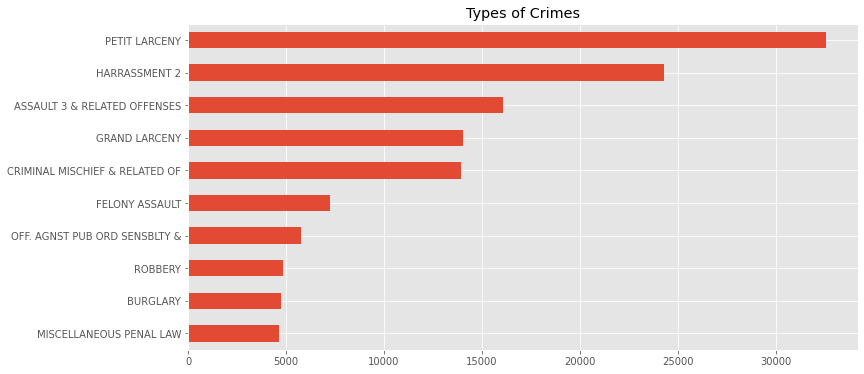

In [41]:
df.OFNS_DESC.value_counts().iloc[:10].sort_values().plot(kind="barh", title = "Types of Crimes")

In [42]:
df.LAW_CAT_CD.unique()

array(['FELONY', 'MISDEMEANOR', 'VIOLATION'], dtype=object)

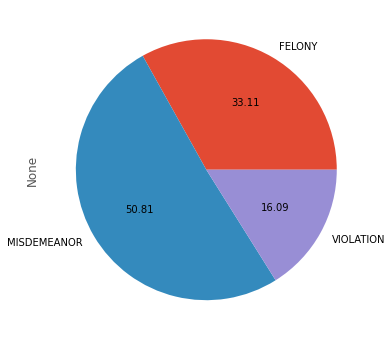

In [43]:
df.groupby('LAW_CAT_CD').size().plot(kind='pie', autopct='%.2f')

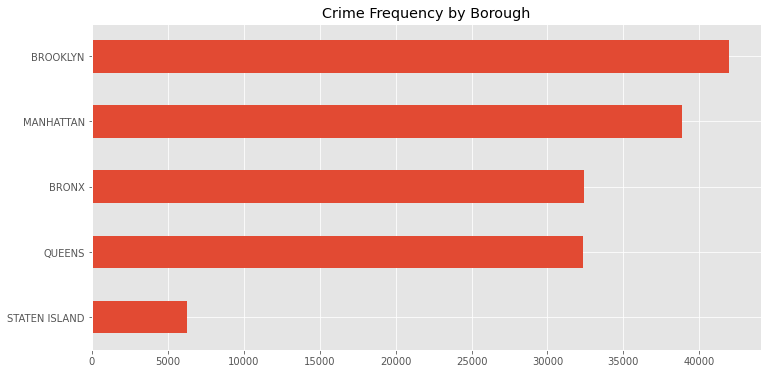

In [44]:
df.BORO_NM.value_counts().iloc[:10].sort_values().plot(kind="barh", title = "Crime Frequency by Borough")

**crime per resident**

To get a clearer image of crime, We use the estimated population by borough to count the crime rate

p.s. The crime rate is a measure of the number of all kinds of recorded crime events for every 100,000 people in a given year.

data source: https://www1.nyc.gov/site/planning/planning-level/nyc-population/current-future-populations.page

Bronx: 1,432,132
Brooklyn: 2,582,830
Manhattan: 1,628,701
Queens: 2,278,906
Staten Island: 476,179

<BarContainer object of 5 artists>

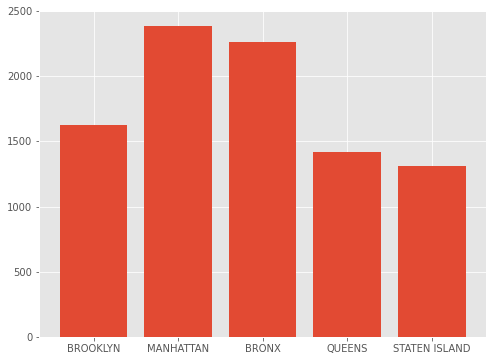

In [45]:
resident_dict = {'Bronx': 1432132, 'Manhattan': 1628701, 'Brooklyn': 2582830, 'Queens': 2278906, 'Staten Island': 476179}
resident_list = [2582830, 1628701, 1432132, 2278906, 476179]
count_table = df['BORO_NM'].value_counts()
count_table

crime_rate_table = count_table / resident_list * 100000

plt.figure(figsize=[8,6])
plt.bar(crime_rate_table.index.tolist(), crime_rate_table.values)

**About Crime Level in each borough**

We broke down to more detail on the same graphic and also show the distribution of each crime level in different district.


LAW_CAT_CD     FELONY  MISDEMEANOR  VIOLATION     All
BORO_NM                                              
BRONX           10780        15848       5799   32427
BROOKLYN        14266        20547       7162   41975
MANHATTAN       12824        21018       5000   38842
QUEENS          10735        16495       5104   32334
STATEN ISLAND    1659         3233       1357    6249
All             50264        77141      24422  151827


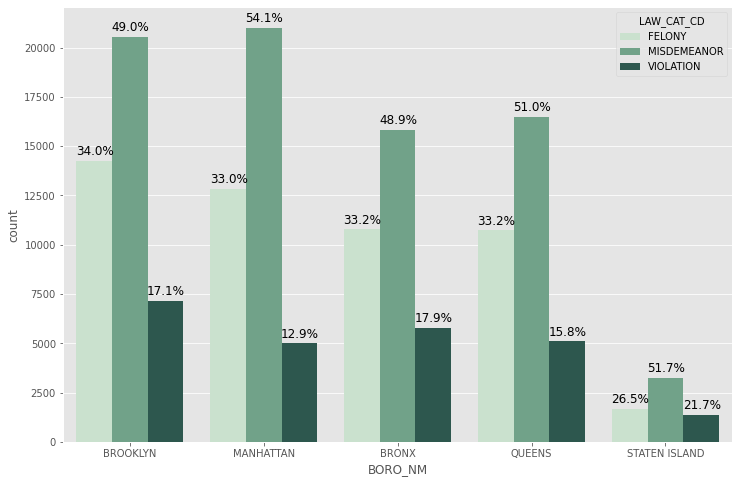

In [46]:
# tabulate a two way table with variables as boroughs and level of crime
two_way_table = pd.crosstab(index=df["BORO_NM"], columns=df["LAW_CAT_CD"], margins=True)
print(two_way_table)

boro_name = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
crime_level = ['VIOLATION', 'MISDEMEANOR', 'FELONY']
subtotal_boro = df.groupby('BORO_NM')['LAW_CAT_CD'].agg('count').sort_values(ascending=False) #total of each boro count
fig = plt.figure(figsize=[12,8])
ax = sns.countplot(x="BORO_NM", hue="LAW_CAT_CD", 
                   data=df[['BORO_NM', 'LAW_CAT_CD']], 
                   order = subtotal_boro.index,
                  palette = "ch:2.5,-.2,dark=.3")

# boro_num = [val for val in range(0, 5) for _ in (0, 1, 2)] #[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4] not work!
boro_num2 = [val for val in range(0, 5)]*3 #[0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,] work for the order
for p, i in zip(ax.patches, boro_num2):
    percent = p.get_height()/subtotal_boro[i]
    ax.annotate('{:.1f}%'. format(percent*100), (p.get_x()+0.138, p.get_height()+300), ha='center', size=12)


In [47]:
df.SUSP_SEX.unique()

array(['M', 'Unknown', 'F'], dtype=object)

In [48]:
handling_first_graph_data = (df[['BORO_NM', 'PATROL_BORO','LAW_CAT_CD']]).fillna('UNKNOWN')
handling_first_graph_data['crime_count'] = [1] * len(handling_first_graph_data.BORO_NM.values)
fig = px.treemap(handling_first_graph_data, path =['BORO_NM', 'PATROL_BORO','LAW_CAT_CD'], values='crime_count')
fig.show()

In [49]:
graph_data = (df[['LAW_CAT_CD', 'PD_DESC']]).fillna('Unknow')
parent_values = list(((graph_data.groupby('LAW_CAT_CD')).count())['PD_DESC'].values)

# we add the new columns , regroup again and reindex data set to label data
graph_data['count'] = [1] * len(graph_data['LAW_CAT_CD'].values)
staced_data= (graph_data.groupby(['LAW_CAT_CD', 'PD_DESC']).count())
sorted_staced_data = staced_data.reindex((staced_data["count"].sort_values(ascending=False)).index.values)

# We prepare label value
label_value = list(sorted_staced_data['count'].values)
total_values= parent_values +  label_value[0:75]
total_values.insert(0,0)

# sepere the index to label and parent labels
parrent_list , label_list = ['','Crime range','Crime range','Crime range' ],['Crime range','FELONY','MISDEMEANOR','VIOLATION']

for index in list(sorted_staced_data.index.values)[0:75] :
    parrent_list.append(index[0])
    label_list.append(index[1])
fig = go.Figure(go.Sunburst( labels = label_list, parents = parrent_list, values = total_values))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

In [50]:
crime_attemp = df[['OFNS_DESC',"CRM_ATPT_CPTD_CD"]]

Filter_data = crime_attemp.loc[(crime_attemp.CRM_ATPT_CPTD_CD == 'COMPLETED')]
Complt_data = Filter_data.groupby(['OFNS_DESC']).count()

Filter_data = crime_attemp.loc[(crime_attemp.CRM_ATPT_CPTD_CD == 'ATTEMPTED')]
Atmpt_data = Filter_data.groupby(['OFNS_DESC']).count()
# Data cleaning to littel bit good visulation
Index_list,Precentage_list_comp,Precentage_list_attmp= [],[],[]
sort_val_list, sort_index_list = [], []

for Index in Complt_data.index.values :
    
    complt_val = Complt_data.loc[(Complt_data.index == Index)].values
    attmp_val = Atmpt_data.loc[(Atmpt_data.index == Index)].values
    if len(attmp_val) == 0 : attmp_val = 0
        
    Sum = (complt_val + attmp_val) 
    
    Attamp_perc = int(((100*attmp_val)/Sum)+1)
    if Attamp_perc >= 5 : 
        Index_list.append(Index)
        Precentage_list_comp.append(int((100*complt_val)/Sum))
        Precentage_list_attmp.append(Attamp_perc)
        sort_val_list.append(Attamp_perc)
        sort_index_list.append(Index)
# sort thenumerical and string values
Precentage_list_attmp.sort(reverse = True)
Precentage_list_comp.sort()

for val in range(len(Precentage_list_attmp)):
    main_index = sort_val_list.index(Precentage_list_attmp[val])
    sort_val_list[main_index] = 0
    Index_list[val] = sort_index_list[main_index]
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Complated', x=Index_list, y=Precentage_list_comp),
    go.Bar(name='Attempted', x=Index_list, y=Precentage_list_attmp)
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [51]:
Race_data = (df[['SUSP_RACE','VIC_RACE']]).fillna('UNKNOWN')
Race_data.loc[Race_data['SUSP_RACE'] == 'Unknown', 'SUSP_RACE'] = 'UNKNOWN'
Race_data['SUSP_RACE'].value_counts(dropna = False)

UNKNOWN                           67069
BLACK                             43810
WHITE HISPANIC                    19551
WHITE                             11213
BLACK HISPANIC                     5895
ASIAN / PACIFIC ISLANDER           4032
AMERICAN INDIAN/ALASKAN NATIVE      257
Name: SUSP_RACE, dtype: int64

In [52]:
Race_data['VIC_RACE'].value_counts(dropna = False)

UNKNOWN                           46709
BLACK                             38108
WHITE HISPANIC                    26649
WHITE                             21561
ASIAN / PACIFIC ISLANDER          12120
BLACK HISPANIC                     6194
AMERICAN INDIAN/ALASKAN NATIVE      486
Name: VIC_RACE, dtype: int64

In [53]:
Indexer = list(Race_data['SUSP_RACE'].unique())
Values_dict = {}
Source = []
Target = []
Data_values_list = zip(list(Race_data['SUSP_RACE'].values),list(Race_data['VIC_RACE'].values))

for sus , vic in Data_values_list:
    try: 
        text = str(sus + "___" + vic)
        Values_dict[text] += 1
    except KeyError:
        Values_dict[text] = 1
        Source.append(Indexer.index(sus))
        Target.append(Indexer.index(vic) + 8)
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.4,),
      label = (Indexer * 2),
      color = ["olive","rosybrown","crimson","lightskyblue","bisque","seagreen","brown","wheat"] * 2
    ),
    link = dict(
      source = Source,
      target = Target,
      value = list(Values_dict.values())
  ))])

fig.update_layout(title_text="suspect race vs victim race", font_size=10)
fig.show()

In [54]:
graph_data = (df[['LAW_CAT_CD','VIC_AGE_GROUP','VIC_RACE']]).dropna()

Crimetype_data= list(graph_data.LAW_CAT_CD.unique())
Vicage_data= list(graph_data.VIC_AGE_GROUP.unique())[0:6]
Vicrace_data= list(graph_data.VIC_RACE.unique())

Indexer = Crimetype_data + Vicage_data + Vicrace_data
Values_dict = {}
Source = []
Target = []
Data_values_list = zip(list(graph_data['LAW_CAT_CD'].values),list(graph_data['VIC_AGE_GROUP'].values),
                       list(graph_data['VIC_RACE'].values))
# For loop to create link map
for sus, vic_age, vic_race in Data_values_list:
    if (vic_age in Vicage_data) and ((sus and vic_age and vic_race) !='UNKNOWN'):
        try: 
            text = str(sus + "___" + vic_age + "___" + vic_race)
            Values_dict[text] += 1
        except KeyError:
            Values_dict[text] = 1
            Source.append(Indexer.index(sus))
            Target.append(Indexer.index(vic_age))
            Source.append(Indexer.index(vic_age))
            Target.append(Indexer.index(vic_race))

import random
color_list = []

def color_creater(List):
    if len(List) == len(Values_dict) :
        return 0
    else:
        first_rgb = random.randint(0,255)
        second_rgb = random.randint(0,255)    
        third_rgb = random.randint(0,255)    
    
        color_text = f"rgba({str(first_rgb)},{str(second_rgb)},{str(third_rgb)},0.1)"
        if color_text not in color_list :
            color_list.append(color_text)
        color_creater(List)

color_creater(color_list)
# And result ....
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.4,),
      label = (Indexer),
      color = ["olive","rosybrown","crimson","lightskyblue","bisque","seagreen","brown","wheat"] * 2
    ),
    link = dict(
      source = Source, 
      target = Target,
      value = list(Values_dict.values()),
      color = color_list
  ))])

fig.update_layout(title_text="level of offence vs victim's age vs victim's race", font_size=10)
fig.show()

Read df and check info

In [113]:
crimeDF = pd.read_csv(os.path.join(cur_dir, data_dir, 'current_cleaned_data.csv'))

In [114]:
crimeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385373 entries, 0 to 385372
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CMPLNT_NUM                385373 non-null  int64  
 1   ADDR_PCT_CD               385373 non-null  float64
 2   BORO_NM                   385373 non-null  object 
 3   zipcode                   385373 non-null  int64  
 4   CRM_ATPT_CPTD_CD          385373 non-null  object 
 5   JURISDICTION_CODE         385373 non-null  int64  
 6   JURIS_DESC                385373 non-null  object 
 7   KY_CD                     385373 non-null  int64  
 8   LAW_CAT_CD                385373 non-null  object 
 9   OFNS_DESC                 385373 non-null  object 
 10  PATROL_BORO               385373 non-null  object 
 11  PD_CD                     385373 non-null  float64
 12  PD_DESC                   385373 non-null  object 
 13  PREM_TYP_DESC             385373 non-null  o

Create a column only for dates

In [115]:
crimeDF['CMPLNT_DT'] = pd.to_datetime(crimeDF['CMPLNT_DT_TS']).dt.date
crimeDF['CMPLNT_DT'] = pd.to_datetime(crimeDF['CMPLNT_DT'])

Find out the first and last date for complaints

In [116]:
first_date = crimeDF["CMPLNT_DT"].min()
last_date = crimeDF["CMPLNT_DT"].max()
print(first_date,last_date)

2022-01-01 00:00:00 2022-09-30 00:00:00


In [117]:
day_count = (last_date - first_date).days + 1
day_count

273

Get a df with all zips and all dates, add 0s to records which does not have a crime on a given date

In [118]:
zips = crimeDF.zipcode.unique()

In [119]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2022, 1, 1)
end_date = date(2022, 10, 1)

In [120]:
dates = []
for single_date in daterange(start_date, end_date):
    dates.append(single_date.strftime("%Y-%m-%d"))

In [121]:
zips = pd.DataFrame(zips)
zips.columns = ['zipcode']
dates = pd.DataFrame(dates)
dates.columns = ['CMPLNT_DT']

In [122]:
zip_date = pd.merge(zips, dates, how ="cross")

In [123]:
zip_date = zip_date.fillna(0)
zip_date['CMPLNT_DT'] = pd.to_datetime(zip_date['CMPLNT_DT'])

In [124]:
recent_pdf = crimeDF

In [125]:
#add new column denoting which category the crime falls in from the above
cat1 = ['MURDER & NON-NEGL. MANSLAUGHTER', 'FELONY ASSAULT']
cat2 = ['RAPE', 'SEX CRIMES', 'FELONY SEX CRIMES', 'OFFENSES RELATED TO CHILDREN', 'KIDNAPPING', 'KIDNAPPING & RELATED OFFENSES']
cat3 = ['ARSON','OFFENSES AGAINST THE PERSON','DANGEROUS WEAPONS','DANGEROUS DRUGS','UNLAWFUL POSS. WEAP. ON SCHOOL','INTOXICATED & IMPAIRED DRIVING','OFFENSES AGAINST PUBLIC SAFETY','HOMICIDE-NEGLIGENT-VEHICLE','INTOXICATED/IMPAIRED DRIVING','ESCAPE 3']
cat4 = ['ROBBERY', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 'BURGLARY', 'UNAUTHORIZED USE OF A VEHICLE', 'THEFT-FRAUD', 'OTHER OFFENSES RELATED TO THEF', 'PETIT LARCENY', 'PETIT LARCENY OF MOTOR VEHICLE']

if 'OffenseCategory' not in recent_pdf.columns:
  recent_pdf['OffenseCategory'] = [""] * len(recent_pdf.index)

recent_pdf['OffenseCategory'] = recent_pdf.apply(lambda x : 'Category1' if x['OFNS_DESC'] in cat1 else ('Category2' if x['OFNS_DESC'] in cat2 else ('Category3' if x['OFNS_DESC'] in cat3 else ('Category4' if x['OFNS_DESC'] in cat4 else 'Other'))), axis = 1)


In [126]:
recent_pdf.to_csv(os.path.join(cur_dir, data_dir, 'current_category_cleaned_data.csv'), index = False)
#TODO fix type datetime -> object
recent_pdf.dtypes.to_csv(os.path.join(cur_dir, data_dir, 'current_category_cleaned_types.csv'), index = False)

In [131]:
datatype_temp = recent_pdf.dtypes
datatype_temp['RPT_DT'] = "object"
datatype_temp['CMPLNT_DT_TS'] = "object"
datatype_temp['CMPLNT_DT'] = "object"

In [132]:
datatype_temp.name = 'types'
datatype_temp.to_csv(os.path.join(cur_dir, data_dir, 'current_category_cleaned_types.csv'), index = False)

In [134]:
pdf_types = pd.read_csv(os.path.join(cur_dir, data_dir, 'current_category_cleaned_types.csv'))['types']
##
pdf = pd.read_csv(os.path.join(cur_dir, data_dir, 'current_category_cleaned_data.csv'), dtype=pdf_types.to_dict(), parse_dates = ['RPT_DT', 'CMPLNT_DT_TS', 'CMPLNT_DT'])

In [135]:
pdf['CMPLNT_DT'] = pd.to_datetime(pdf['CMPLNT_DT_TS']).dt.date
pdf['CMPLNT_DT'] = pd.to_datetime(pdf['CMPLNT_DT'])

In [136]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385373 entries, 0 to 385372
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CMPLNT_NUM                385373 non-null  int64         
 1   ADDR_PCT_CD               385373 non-null  float64       
 2   BORO_NM                   385373 non-null  object        
 3   zipcode                   385373 non-null  int64         
 4   CRM_ATPT_CPTD_CD          385373 non-null  object        
 5   JURISDICTION_CODE         385373 non-null  int64         
 6   JURIS_DESC                385373 non-null  object        
 7   KY_CD                     385373 non-null  int64         
 8   LAW_CAT_CD                385373 non-null  object        
 9   OFNS_DESC                 385373 non-null  object        
 10  PATROL_BORO               385373 non-null  object        
 11  PD_CD                     385373 non-null  float64       
 12  PD

Create a df with zipcode, date and crime counts for various categories

In [137]:
q1 = """SELECT zipcode, CMPLNT_DT, OffenseCategory, count(OffenseCategory) as cat_count 
       FROM pdf
       group by zipcode, CMPLNT_DT, OffenseCategory;"""

adf1 = sqldf(q1, globals())

In [138]:
adf1['OffenseCategory'].value_counts()

Other        42321
Category4    40828
Category1    10597
Category3    10415
Category2     4821
Name: OffenseCategory, dtype: int64

In [139]:
table1 = pd.pivot_table(adf1, values='cat_count', index=['zipcode', 'CMPLNT_DT'], columns=['OffenseCategory'], aggfunc=np.sum).fillna(0).reset_index()

In [140]:
table1

OffenseCategory,zipcode,CMPLNT_DT,Category1,Category2,Category3,Category4,Other
0,7002,2022-01-16 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
1,7002,2022-01-20 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
2,7002,2022-03-16 00:00:00.000000,0.0,0.0,0.0,0.0,2.0
3,7002,2022-05-02 00:00:00.000000,0.0,0.0,0.0,1.0,0.0
4,7002,2022-05-30 00:00:00.000000,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
46651,11697,2022-07-13 00:00:00.000000,0.0,0.0,0.0,1.0,2.0
46652,11697,2022-07-16 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
46653,11697,2022-07-21 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
46654,11697,2022-07-25 00:00:00.000000,0.0,0.0,1.0,0.0,0.0


In [141]:
table1['CMPLNT_DT'] = pd.to_datetime(table1['CMPLNT_DT'])

In [142]:
table1

OffenseCategory,zipcode,CMPLNT_DT,Category1,Category2,Category3,Category4,Other
0,7002,2022-01-16,0.0,0.0,0.0,0.0,1.0
1,7002,2022-01-20,0.0,0.0,0.0,0.0,1.0
2,7002,2022-03-16,0.0,0.0,0.0,0.0,2.0
3,7002,2022-05-02,0.0,0.0,0.0,1.0,0.0
4,7002,2022-05-30,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
46651,11697,2022-07-13,0.0,0.0,0.0,1.0,2.0
46652,11697,2022-07-16,0.0,0.0,0.0,0.0,1.0
46653,11697,2022-07-21,0.0,0.0,0.0,0.0,1.0
46654,11697,2022-07-25,0.0,0.0,1.0,0.0,0.0


In [143]:
zip_date_cat_countDF = zip_date.merge(table1, how='left', on=['zipcode','CMPLNT_DT'])

In [144]:
zip_date_cat_countDF = zip_date_cat_countDF.fillna(0)

In [145]:
zip_date_cat_countDF

,zipcode,CMPLNT_DT,Category1,Category2,Category3,Category4,Other
0,10462,2022-01-01,0.0,0.0,0.0,1.0,2.0
1,10462,2022-01-02,0.0,0.0,0.0,1.0,7.0
2,10462,2022-01-03,0.0,0.0,0.0,4.0,4.0
3,10462,2022-01-04,0.0,0.0,0.0,2.0,5.0
4,10462,2022-01-05,0.0,0.0,0.0,4.0,8.0
...,...,...,...,...,...,...,...
53503,7077,2022-09-26,0.0,0.0,0.0,0.0,0.0
53504,7077,2022-09-27,0.0,0.0,0.0,0.0,0.0
53505,7077,2022-09-28,0.0,0.0,0.0,0.0,0.0
53506,7077,2022-09-29,0.0,0.0,0.0,0.0,0.0


Forecast using ARIMA

In [146]:
def forecast_pred_ARIMA_new(zip):
  df = zip_date_cat_countDF.loc[zip_date_cat_countDF['zipcode'] == zip]
  train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]

  modelARIMA_Category1 = ARIMA(train.Category1, order=(2,1,0)).fit()
  modelARIMA_Category2 = ARIMA(train.Category2, order=(2,1,0)).fit()
  modelARIMA_Category3 = ARIMA(train.Category3, order=(2,1,0)).fit()
  modelARIMA_Category4 = ARIMA(train.Category4, order=(2,1,0)).fit()

  Category1_pred = modelARIMA_Category1.get_forecast(len(test.index))
  Category2_pred = modelARIMA_Category2.get_forecast(len(test.index))
  Category3_pred = modelARIMA_Category3.get_forecast(len(test.index))
  Category4_pred = modelARIMA_Category4.get_forecast(len(test.index))

  Category1_pred_df = Category1_pred.conf_int(alpha = 0.05)
  Category2_pred_df = Category2_pred.conf_int(alpha = 0.05)
  Category3_pred_df = Category3_pred.conf_int(alpha = 0.05) 
  Category4_pred_df = Category4_pred.conf_int(alpha = 0.05) 

  Category1_pred_df["Predictions"] = modelARIMA_Category1.predict(start = Category1_pred_df.index[0], end = Category1_pred_df.index[-1])
  Category2_pred_df["Predictions"] = modelARIMA_Category2.predict(start = Category2_pred_df.index[0], end = Category2_pred_df.index[-1])
  Category3_pred_df["Predictions"] = modelARIMA_Category3.predict(start = Category3_pred_df.index[0], end = Category3_pred_df.index[-1])
  Category4_pred_df["Predictions"] = modelARIMA_Category4.predict(start = Category4_pred_df.index[0], end = Category4_pred_df.index[-1])

  Category1_pred_df.index = test.index
  Category2_pred_df.index = test.index
  Category3_pred_df.index = test.index
  Category4_pred_df.index = test.index

  Category1_pred_out = Category1_pred_df["Predictions"]
  Category2_pred_out = Category2_pred_df["Predictions"]
  Category3_pred_out = Category3_pred_df["Predictions"]
  Category4_pred_out = Category4_pred_df["Predictions"]

  # Uncomment for plots
  
  # forecast_error_Category1 = test["Category1"] - Category1_pred_out
  # forecast_error_Category2 = test["Category2"] - Category2_pred_out
  # forecast_error_Category3 = test["Category3"] - Category3_pred_out
  # forecast_error_Category4 = test["Category4"] - Category4_pred_out

  # print("RMSE, MFE for Category1 = ", str(np.sqrt(mean_squared_error(test["Category1"], forecast_error_Category1))), str(np.mean(forecast_error_Category1)))
  # print("RMSE, MFE for Category2 = ", str(np.sqrt(mean_squared_error(test["Category2"], forecast_error_Category2))), str(np.mean(forecast_error_Category2)))
  # print("RMSE, MFE for Category3 = ", str(np.sqrt(mean_squared_error(test["Category3"], forecast_error_Category3))), str(np.mean(forecast_error_Category3)))
  # print("RMSE, MFE for Category4 = ", str(np.sqrt(mean_squared_error(test["Category4"], forecast_error_Category4))), str(np.mean(forecast_error_Category4)))

  # fig, axs = plt.subplots(4, figsize=(18,14))
  # fig.suptitle('ARIMA Model Results')
  # # Category1
  # axs[0].plot(test['CMPLNT_DT'], test['Category1'])
  # axs[0].plot(test['CMPLNT_DT'],Category1_pred_out)
  # axs[0].set_title('Predicted Category1')
  # # Category2
  # axs[1].plot(test['CMPLNT_DT'], test['Category2'])
  # axs[1].plot(test['CMPLNT_DT'],Category2_pred_out)
  # axs[1].set_title('Predicted Category2')
  # # Category3
  # axs[2].plot(test['CMPLNT_DT'], test['Category3'])
  # axs[2].plot(test['CMPLNT_DT'],Category3_pred_out)
  # axs[2].set_title('Predicted Category3')
  # # Category4
  # axs[3].plot(test['CMPLNT_DT'], test['Category4'])
  # axs[3].plot(test['CMPLNT_DT'],Category4_pred_out)
  # axs[3].set_title('Predicted Category4')

  # for ax in axs.flat:
  #   ax.set(xlabel='Time', ylabel= 'Crime Count')

  # # Hide x labels and tick labels for top plots and y ticks for right plots.
  # for ax in axs.flat:
  #     ax.label_outer()

  return np.array(Category1_pred_out), np.array(Category2_pred_out), np.array(Category3_pred_out), np.array(Category4_pred_out)

Forecast using Auto ARIMA

In [147]:
def forecast_pred_Auto_ARIMA_new(zip):
  df = zip_date_cat_countDF.loc[zip_date_cat_countDF['zipcode'] == zip]
  train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]

  # Category1
  stepwise_model_Category1 = auto_arima(df.Category1, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category1.fit(train.Category1)
  future_forecast_Category1 = stepwise_model_Category1.predict(n_periods=30)
  # Category2
  stepwise_model_Category2 = auto_arima(df.Category2, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category2.fit(train.Category2)
  future_forecast_Category2 = stepwise_model_Category2.predict(n_periods=30)
  # Category3
  stepwise_model_Category3 = auto_arima(df.Category3, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category3.fit(train.Category3)
  future_forecast_Category3 = stepwise_model_Category3.predict(n_periods=30)
  # Category4
  stepwise_model_Category4 = auto_arima(df.Category4, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category4.fit(train.Category4)
  future_forecast_Category4 = stepwise_model_Category4.predict(n_periods=30)


  # Uncomment for graphs

  # forecast_error_Category1 = test["Category1"] - future_forecast_Category1
  # forecast_error_Category2 = test["Category2"] - future_forecast_Category2
  # forecast_error_Category3 = test["Category3"] - future_forecast_Category3
  # forecast_error_Category4 = test["Category4"] - future_forecast_Category4

  # print("RMSE, MFE for Category1 = ", str(np.sqrt(mean_squared_error(test["Category1"], future_forecast_Category1))), str(np.mean(forecast_error_Category1)))
  # print("RMSE, MFE for Category2 = ", str(np.sqrt(mean_squared_error(test["Category2"], future_forecast_Category2))), str(np.mean(forecast_error_Category2)))
  # print("RMSE, MFE for Category3 = ", str(np.sqrt(mean_squared_error(test["Category3"], future_forecast_Category3))), str(np.mean(forecast_error_Category3)))
  # print("RMSE, MFE for Category4 = ", str(np.sqrt(mean_squared_error(test["Category4"], future_forecast_Category4))), str(np.mean(forecast_error_Category4)))

  # fig, axs = plt.subplots(4, figsize=(20,14))
  # fig.suptitle('Auto ARIMA Model Results')
  # # Category1
  # axs[0].plot(test['CMPLNT_DT'], test['Category1'])
  # # axs[0].set_title('Actual Felony')
  # axs[0].plot(test['CMPLNT_DT'],future_forecast_Category1)
  # ttle_Felony = 'Predicted Category1 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category1"], future_forecast_Category1)))
  # axs[0].set_title('Category1')
  # axs[0].legend(['actual','predicted'])
  # # Category2
  # axs[1].plot(test['CMPLNT_DT'], test['Category2'])
  # # axs[1].set_title('Actual Misdemeanor')
  # axs[1].plot(test['CMPLNT_DT'],future_forecast_Category2)
  # ttle_Misdemeanor = 'Predicted Category2 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category2"], future_forecast_Category2)))
  # axs[1].set_title('Category2')
  # axs[1].legend(['actual','predicted'])
  # # Category3
  # axs[2].plot(test['CMPLNT_DT'], test['Category3'])
  # # axs[2].set_title('Actual Violation')
  # axs[2].plot(test['CMPLNT_DT'],future_forecast_Category3)
  # ttle_Violation = 'Predicted Category3 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category3"], future_forecast_Category3)))
  # axs[2].set_title('Category3')
  # axs[2].legend(['actual','predicted'])
  # # Category4
  # axs[3].plot(test['CMPLNT_DT'], test['Category4'])
  # # axs[2].set_title('Actual Violation')
  # axs[3].plot(test['CMPLNT_DT'],future_forecast_Category4)
  # ttle_Violation = 'Predicted Category4 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category4"], future_forecast_Category4)))
  # axs[3].set_title('Category4')
  # axs[3].legend(['actual','predicted'])

  # for ax in axs.flat:
  #   ax.set(xlabel='Time', ylabel= 'Crime Count')

  # # Hide x labels and tick labels for top plots and y ticks for right plots.
  # for ax in axs.flat:
  #     ax.label_outer()

  return np.array(future_forecast_Category1),np.array(future_forecast_Category2),np.array(future_forecast_Category3),np.array(future_forecast_Category4)

In [148]:
def zip_arima_pred():
  zipcode_list = np.array(zips['zipcode'])
  zip_pred_dict = {}
  i = 0
  for zip in zipcode_list:
    # uncomment to track progress
    # print("i = ",i)
    # i+=1
    cat1_pred, cat2_pred, cat3_pred, cat4_pred = forecast_pred_ARIMA_new(zip)
    zip_pred_dict[zip] = [cat1_pred, cat2_pred, cat3_pred, cat4_pred]
  return zip_pred_dict

Store predicted values and create a csv

In [149]:
predictions_ARIMA_dict = zip_arima_pred()
df_arima_pred = pd.DataFrame.from_dict(predictions_ARIMA_dict,orient='index')
df_arima_pred.reset_index(inplace=True)
df_arima_pred.columns = ['zipcode','Category1', 'Category2', 'Category3', 'Category4']
df_arima_pred = df_arima_pred.explode(['Category1', 'Category2', 'Category3', 'Category4'])


In [150]:
df_arima_pred

,zipcode,Category1,Category2,Category3,Category4
0,10462,0.0,0.0,0.382057,2.659298
0,10462,0.0,0.0,0.456396,2.515008
0,10462,0.0,0.0,0.265281,3.08669
0,10462,0.0,0.0,0.37993,2.747608
0,10462,0.0,0.0,0.363389,2.777144
...,...,...,...,...,...
195,7077,0.0,0.0,0.0,0.0
195,7077,0.0,0.0,0.0,0.0
195,7077,0.0,0.0,0.0,0.0
195,7077,0.0,0.0,0.0,0.0


In [151]:
start_date_pred = date(2022, 9, 1)
end_date_pred = date(2022, 10, 1)

In [152]:
dates_pred = []
for single_date in daterange(start_date_pred, end_date_pred):
    dates_pred.append(single_date.strftime("%Y-%m-%d"))

In [153]:
dates_pred_list = dates_pred * len(np.array(zips['zipcode']))

In [154]:
df_arima_pred['Date'] = dates_pred_list

In [155]:
zip_data = pd.DataFrame(pd.unique(df_arima_pred['zipcode']))

In [156]:
df_arima_pred.to_csv('ARIMA_pred.csv', index=False)

In [157]:
zip_data.to_csv('Zips.csv', index=False)

In [158]:
zip_date_cat_countDF.to_csv('zip_cat_count.csv', index=False)

In [159]:
zip_date_cat_countDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53508 entries, 0 to 53507
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   zipcode    53508 non-null  int64         
 1   CMPLNT_DT  53508 non-null  datetime64[ns]
 2   Category1  53508 non-null  float64       
 3   Category2  53508 non-null  float64       
 4   Category3  53508 non-null  float64       
 5   Category4  53508 non-null  float64       
 6   Other      53508 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.3 MB


In [160]:
zip_date_cat_countDF = pd.read_csv('/content/zip_cat_count.csv')
zip_date_cat_countDF['CMPLNT_DT'] = pd.to_datetime(zip_date_cat_countDF['CMPLNT_DT'])
zips = pd.read_csv('/content/Zips.csv')
zips.columns = ['zipcode']
zips = np.array(zips['zipcode'])

In [161]:
def zip_auto_arima_pred():
  zip_pred_dict = {}
  i = 0
  for zip in zips:
    # uncomment to track progress
    print("i = ",i)
    i+=1
    cat1_pred, cat2_pred, cat3_pred, cat4_pred = forecast_pred_Auto_ARIMA_new(zip)
    zip_pred_dict[zip] = [cat1_pred, cat2_pred, cat3_pred, cat4_pred]
  return zip_pred_dict

Below code takes long time to run. Uncomment to verify. The output was saved and the file was used for cluster prediction.

In [162]:
# predictions_Auto_ARIMA_dict = zip_auto_arima_pred()

In [163]:
# df_auto_arima_pred = pd.DataFrame.from_dict(predictions_Auto_ARIMA_dict,orient='index')
# df_auto_arima_pred.reset_index(inplace=True)
# df_auto_arima_pred.columns = ['zipcode','Category1', 'Category2', 'Category3', 'Category4']
# df_auto_arima_pred = df_auto_arima_pred.explode(['Category1', 'Category2', 'Category3', 'Category4'])

In [164]:
# df_auto_arima_pred

In [165]:
# df_auto_arima_pred['Date'] = dates_pred_list

In [166]:
# df_auto_arima_pred.to_csv('Auto_ARIMA_pred.csv', index=False)

In [167]:
# files.download("Auto_ARIMA_pred.csv")

In [168]:
preddf = pd.read_csv(os.path.join(cur_dir, data_dir, 'Auto_ARIMA_pred.csv'))
zip_date_cat_countDF = pd.read_csv('zip_cat_count.csv')
arima_preddf = pd.read_csv('ARIMA_pred.csv')

In [169]:
def Auto_Arima_Scores(zip_date_cat_countDF,preddf):
  zip_date_cat_countDF = zip_date_cat_countDF.sort_values(by=['zipcode','CMPLNT_DT'])
  df = zip_date_cat_countDF
  # df = df.sort_values(by=['zipcode'])
  # train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  df['CMPLNT_DT'] = pd.to_datetime(df['CMPLNT_DT'])
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = test.sort_values(by=['zipcode','CMPLNT_DT'])
  preddf['Date'] = pd.to_datetime(preddf['Date'])
  preddf = preddf.sort_values(by=['zipcode','Date'])
  y_cat1_true = test['Category1']
  y_cat2_true = test['Category2']
  y_cat3_true = test['Category3']
  y_cat4_true = test['Category4']

  # Auto ARIMA
  y_cat1_pred = preddf['Category1']
  y_cat2_pred = preddf['Category2']
  y_cat3_pred = preddf['Category3']
  y_cat4_pred = preddf['Category4']
  #MSE
  MSE_cat1 = np.square(np.subtract(y_cat1_true,y_cat1_pred)).mean() 
  MSE_cat2 = np.square(np.subtract(y_cat2_true,y_cat2_pred)).mean() 
  MSE_cat3 = np.square(np.subtract(y_cat3_true,y_cat3_pred)).mean() 
  MSE_cat4 = np.square(np.subtract(y_cat4_true,y_cat4_pred)).mean() 
  #RMSE
  RMSE_cat1 = math.sqrt(MSE_cat1)
  RMSE_cat2 = math.sqrt(MSE_cat2)
  RMSE_cat3 = math.sqrt(MSE_cat3)
  RMSE_cat4 = math.sqrt(MSE_cat4)

  #MFE
  forecast_error_cat1 = y_cat1_true - y_cat1_pred
  MFE_cat1 = np.mean(forecast_error_cat1)
  forecast_error_cat2 = y_cat2_true - y_cat2_pred
  MFE_cat2 = np.mean(forecast_error_cat2)
  forecast_error_cat3 = y_cat3_true - y_cat3_pred
  MFE_cat3 = np.mean(forecast_error_cat3)
  forecast_error_cat4 = y_cat4_true - y_cat4_pred
  MFE_cat4 = np.mean(forecast_error_cat4)

  print("RMSE for Auto Arima (Cat1,2,3,4) are - ",RMSE_cat1, RMSE_cat2, RMSE_cat3, RMSE_cat4)
  print("MFE for Auto Arima (Cat1,2,3,4) are - ",MFE_cat1, MFE_cat2, MFE_cat3, MFE_cat4)

In [170]:
zip_date_cat_countDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53508 entries, 0 to 53507
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   zipcode    53508 non-null  int64  
 1   CMPLNT_DT  53508 non-null  object 
 2   Category1  53508 non-null  float64
 3   Category2  53508 non-null  float64
 4   Category3  53508 non-null  float64
 5   Category4  53508 non-null  float64
 6   Other      53508 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.9+ MB


In [171]:
Auto_Arima_Scores(zip_date_cat_countDF,preddf)

RMSE for Auto Arima (Cat1,2,3,4) are -  1.5933568613334068 0.7159793236299165 1.3064188113355757 4.69168563535207
MFE for Auto Arima (Cat1,2,3,4) are -  0.7446775276253969 0.17777961482982332 0.2943525830492066 1.4118705463252805


In [172]:
def Arima_Scores(zip_date_cat_countDF,arima_preddf):
  zip_date_cat_countDF = zip_date_cat_countDF.sort_values(by=['zipcode','CMPLNT_DT'])
  df = zip_date_cat_countDF
  # df = df.sort_values(by=['zipcode'])
  # train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  df['CMPLNT_DT'] = pd.to_datetime(df['CMPLNT_DT'])
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = test.sort_values(by=['zipcode','CMPLNT_DT'])
  arima_preddf['Date'] = pd.to_datetime(arima_preddf['Date'])
  arima_preddf = arima_preddf.sort_values(by=['zipcode','Date'])
  y_cat1_true = test['Category1']
  y_cat2_true = test['Category2']
  y_cat3_true = test['Category3']
  y_cat4_true = test['Category4']

  # Auto ARIMA
  y_cat1_pred = arima_preddf['Category1']
  y_cat2_pred = arima_preddf['Category2']
  y_cat3_pred = arima_preddf['Category3']
  y_cat4_pred = arima_preddf['Category4']
  #MSE
  MSE_cat1 = np.square(np.subtract(y_cat1_true,y_cat1_pred)).mean() 
  MSE_cat2 = np.square(np.subtract(y_cat2_true,y_cat2_pred)).mean() 
  MSE_cat3 = np.square(np.subtract(y_cat3_true,y_cat3_pred)).mean() 
  MSE_cat4 = np.square(np.subtract(y_cat4_true,y_cat4_pred)).mean() 
  #RMSE
  RMSE_cat1 = math.sqrt(MSE_cat1)
  RMSE_cat2 = math.sqrt(MSE_cat2)
  RMSE_cat3 = math.sqrt(MSE_cat3)
  RMSE_cat4 = math.sqrt(MSE_cat4)

  #MFE
  forecast_error_cat1 = y_cat1_true - y_cat1_pred
  MFE_cat1 = np.mean(forecast_error_cat1)
  forecast_error_cat2 = y_cat2_true - y_cat2_pred
  MFE_cat2 = np.mean(forecast_error_cat2)
  forecast_error_cat3 = y_cat3_true - y_cat3_pred
  MFE_cat3 = np.mean(forecast_error_cat3)
  forecast_error_cat4 = y_cat4_true - y_cat4_pred
  MFE_cat4 = np.mean(forecast_error_cat4)

  print("RMSE for Arima (Cat1,2,3,4) are - ",RMSE_cat1, RMSE_cat2, RMSE_cat3, RMSE_cat4)
  print("MFE for Arima (Cat1,2,3,4) are - ",MFE_cat1, MFE_cat2, MFE_cat3, MFE_cat4)

In [173]:
Arima_Scores(zip_date_cat_countDF,arima_preddf)

RMSE for Arima (Cat1,2,3,4) are -  1.5534827821172859 0.6817031708334375 1.2621301489440826 4.687220121842255
MFE for Arima (Cat1,2,3,4) are -  0.7591056159844666 0.19848008391217442 0.2629747163856397 1.4879426025337028


Unsupervised Clustering to define ground truth labels

In [191]:
recent_pdf = pdf
recent_pdf.loc[:, ['zipcode']] = recent_pdf['zipcode'].astype(str).apply(lambda x: x.zfill(5))

In [192]:
#set Year to the right value using CMPLNT_FR_DT
recent_pdf['Year'] = recent_pdf['CMPLNT_DT_TS'].dt.year
# recent_pdf.info()


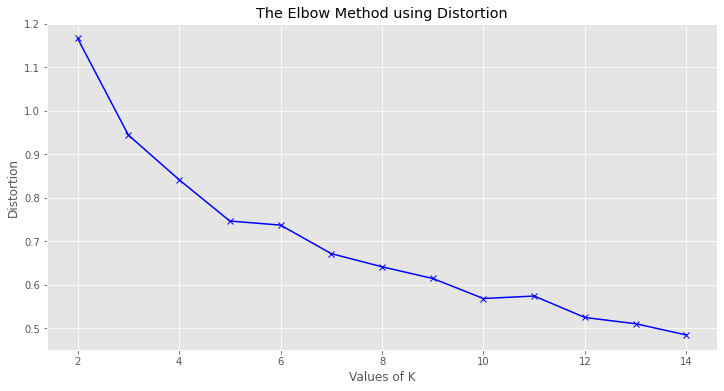

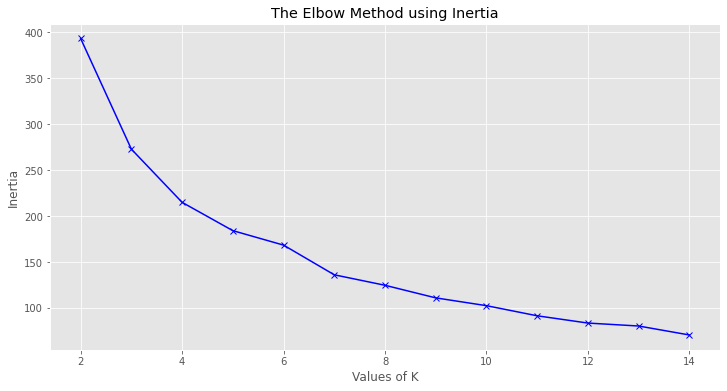

In [193]:
cat1 = ['MURDER & NON-NEGL. MANSLAUGHTER', 'FELONY ASSAULT']
cat2 = ['RAPE', 'SEX CRIMES', 'FELONY SEX CRIMES', 'OFFENSES RELATED TO CHILDREN', 'KIDNAPPING', 'KIDNAPPING & RELATED OFFENSES']
cat3 = ['ARSON','OFFENSES AGAINST THE PERSON','DANGEROUS WEAPONS','DANGEROUS DRUGS','UNLAWFUL POSS. WEAP. ON SCHOOL','INTOXICATED & IMPAIRED DRIVING','OFFENSES AGAINST PUBLIC SAFETY','HOMICIDE-NEGLIGENT-VEHICLE','INTOXICATED/IMPAIRED DRIVING','ESCAPE 3']
cat4 = ['ROBBERY', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 'BURGLARY', 'UNAUTHORIZED USE OF A VEHICLE', 'THEFT-FRAUD', 'OTHER OFFENSES RELATED TO THEF', 'PETIT LARCENY', 'PETIT LARCENY OF MOTOR VEHICLE']


counts_by_year_zip_cat = recent_pdf.loc[:, ['CMPLNT_NUM', 'Year', 'zipcode', 'OFNS_DESC']].groupby(by = ['Year', 'zipcode', 'OFNS_DESC']).count()
input_data = pd.DataFrame(columns = ['zipcode', 'Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count'])
for zip in counts_by_year_zip_cat.index.levels[1]:
  zip_counts = counts_by_year_zip_cat.xs(zip, level='zipcode')
  
  cat1Count, cat2Count, cat3Count, cat4Count = 0, 0, 0, 0

  for c1 in cat1:
    if c1 in zip_counts.index.get_level_values(1):
      cat1Count += zip_counts.xs(c1, level = 'OFNS_DESC').sum()[0]
  
  for c2 in cat2:
    if c2 in zip_counts.index.get_level_values(1):
      cat2Count += zip_counts.xs(c2, level = 'OFNS_DESC').sum()[0]
  
  for c3 in cat3:
    if c3 in zip_counts.index.get_level_values(1):
      cat3Count += zip_counts.xs(c3, level = 'OFNS_DESC').sum()[0]
  
  for c4 in cat4:
    if c4 in zip_counts.index.get_level_values(1):
      cat4Count += zip_counts.xs(c4, level = 'OFNS_DESC').sum()[0]
  input_data.loc[len(input_data.index), : ] = [zip, cat1Count, cat2Count, cat3Count, cat4Count]



from sklearn import preprocessing
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

X_train = input_data.loc[:, ['Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count']].values
scaler = preprocessing.StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)



#unsupervised classification of zipcodes
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

k_vals = list(range(2,15))
distortions = []
inertias = []
for k in k_vals:
  kmeans = KMeans(init="k-means++", n_clusters=k, n_init=4, random_state=7)
  kmeans = kmeans.fit(X_scaled)
  labels = kmeans.labels_

  distortions.append(sum(np.min(cdist(X_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])
  inertias.append(kmeans.inertia_)

  #visualising clusters in 2d
  features = X_scaled

  tsne = TSNE(n_components=2, random_state=0)
  projections = tsne.fit_transform(features)

  fig = px.scatter(
      projections, x=0, y=1,
      color=labels, labels={'color': 'Cluster ID'}
  )
  fig.show()

plt.plot(k_vals, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


plt.plot(k_vals, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Unsupervised Clustering with k = 7 (best parameter after hyper parameter tuning)

In [194]:
X_train = input_data.loc[:, ['Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count']].values
scaler = preprocessing.StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)



#unsupervised classification of zipcodes
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

best_k = 7

kmeans = KMeans(init="k-means++", n_clusters=best_k, n_init=4, random_state=7)
kmeans = kmeans.fit(X_scaled)
labels = kmeans.labels_

#visualising clusters in 2d
features = X_scaled

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

fig = px.scatter(
    projections, x=0, y=1,
    color=labels, labels={'color': 'Cluster ID'}
)
fig.show()

print(kmeans.cluster_centers_)

[[-5.68662509e-01 -6.40184766e-01 -6.69850888e-01 -8.45399972e-01]
 [ 2.00478994e+00  1.69143280e+00  3.37165641e+00  1.44058361e+00]
 [-1.01036932e-01 -8.64298822e-04  7.89806271e-01  1.86531669e+00]
 [ 1.64233528e+00  1.95691658e+00  1.04051305e+00  7.51473369e-01]
 [ 4.88989735e-01  7.26739733e-01 -3.71560081e-02  1.18166389e-01]
 [ 4.57142659e+00  2.82635318e+00  2.24081426e+00  1.23219109e+00]
 [-5.57608308e-01 -6.13397958e-01 -3.16508942e-02  2.11508072e-01]]


In [204]:
#Un-normalized centroids
scaler.scale_ * kmeans.cluster_centers_ + scaler.mean_

array([[2.16666667e+00, 1.01190476e+00, 1.68571429e+01, 2.64380952e+02],
       [4.42666667e+02, 1.07500000e+02, 3.62333333e+02, 1.72516667e+03],
       [8.22105263e+01, 3.02105263e+01, 1.41631579e+02, 1.99657895e+03],
       [3.80625000e+02, 1.19625000e+02, 1.63062500e+02, 1.28481250e+03],
       [1.83205882e+02, 6.34411765e+01, 7.09411765e+01, 8.80117647e+02],
       [8.82000000e+02, 1.59333333e+02, 2.65666667e+02, 1.59200000e+03],
       [4.05882353e+00, 2.23529412e+00, 7.14117647e+01, 9.39764706e+02]])

In [196]:
ground_truth_data = input_data
ground_truth_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 195
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   zipcode    196 non-null    object
 1   Cat1Count  196 non-null    object
 2   Cat2Count  196 non-null    object
 3   Cat3Count  196 non-null    object
 4   Cat4Count  196 non-null    object
dtypes: object(5)
memory usage: 13.3+ KB


KNN classification with 80-20 split on 196 zipcodes

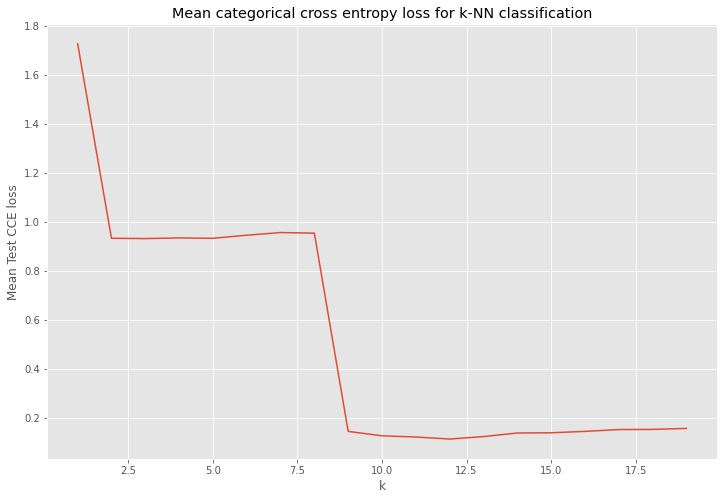

In [205]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

#Scale data as required

X = ground_truth_data.loc[:, ['Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count']].values #predicted count for day
# X_scaled = scaler.transform(X * 272)  #'Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count' for year, scaled
X_scaled = scaler.transform(X)

X_train = X_scaled[:int(196*0.8), :]

X_test = X_scaled[int(196*0.8):, :]
# y = kmeans.labels_ #based on 'Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count' for year, scaled
y = kmeans.predict(X_scaled)
y_train = y[:int(196*0.8)]
y_test = y[int(196*0.8):]

# k_vals = [3,5,7,9]
k_vals = list(range(1,20))
cce_losses = []
for k in k_vals:
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train, y_train)
  predicted_probs = neigh.predict_proba(X_test) #num_zips x num_clusters
  cce_loss = log_loss(y_test, predicted_probs, labels = list(range(0,7)))
  cce_losses.append(cce_loss)

plt.figure(figsize = (12,8))
plt.plot(k_vals, cce_losses)
plt.title('Mean categorical cross entropy loss for k-NN classification')
plt.xlabel('k')
plt.ylabel('Mean Test CCE loss')

plt.show()

KNN classification with best k(9)

In [207]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

#Scale data as required
# predicted_data = pd.read_csv(os.path.join(cur_dir, data_dir, 'ARIMA_pred.csv'))
predicted_data = pd.read_csv(os.path.join(cur_dir, data_dir, 'Auto_ARIMA_pred.csv'))
X_new = predicted_data.loc[:, ['Category1', 'Category2', 'Category3', 'Category4']].values

X = ground_truth_data.loc[:, ['Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count']].values #predicted count for day

X_scaled = scaler.transform(X)
X_new_scaled = scaler.transform(X_new * 272.)

y = kmeans.predict(X_scaled)

k_best = 9
#choose best k for knn
#output clusters for each day for last 30 days
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_scaled, y)
outputs = neigh.predict(X_new_scaled)
predicted_data.loc[:, ['predicted_cluster']] = outputs


In [209]:
zip_features = input_data.loc[:, ['Cat1Count', 'Cat2Count', 'Cat3Count', 'Cat4Count']].values
# scaler = preprocessing.StandardScaler().fit(X_train)

scaled_zip_features = scaler.transform(zip_features)

In [210]:
gt_clusters = kmeans.predict(scaled_zip_features)


Ground truth cluster Ids for each zip

In [201]:
gt_clusters_dict = {}
i = 0
for zip in input_data.loc[:, ['zipcode']].values:
  gt_clusters_dict[zip[0]] = gt_clusters[i]
  i += 1


Confusion matrix for overall cluster id vs september's predicted cluster id to measure temporal variance

() (5880,)
{0, 1, 2, 3, 4, 5, 6} {0, 1, 2, 3, 4, 6}


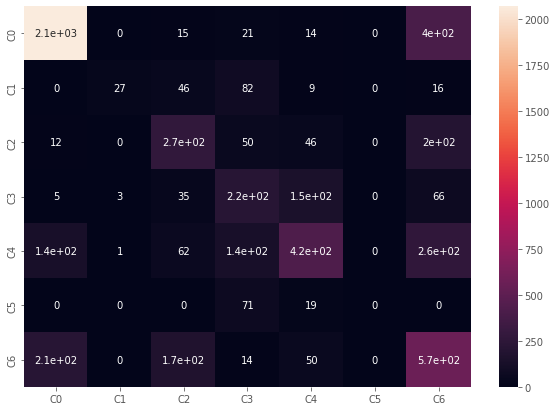

In [203]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

predicted_data.loc[:, ['zipcode']] = predicted_data['zipcode'].astype(str).apply(lambda x: x.zfill(5))
y_true = [gt_clusters_dict[str(zip[0])] for zip in predicted_data.loc[:, ['zipcode']].values]
y_pred = predicted_data['predicted_cluster'].values
print(y_true[0].shape, y_pred.shape)
print(set(y_true), set(y_pred))
cm = confusion_matrix(y_true, y_pred, labels = [i for i in range(0,7)])

df_cm = pd.DataFrame(cm, index = [f'C{i}' for i in "0123456"],
                  columns = [f'C{i}' for i in "0123456"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)